In [1]:
# Install necessary libraries
!pip install networkx matplotlib scikit-learn pandas numpy python-louvain community -q
print("✅ Libraries installed successfully!")

✅ Libraries installed successfully!


In [2]:
# Import libraries
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import requests
import gzip
import io
import warnings
warnings.filterwarnings('ignore')

# Load Facebook data from Stanford SNAP
print("📥 Loading Facebook data from Stanford SNAP...")
url = "https://snap.stanford.edu/data/facebook_combined.txt.gz"
response = requests.get(url)
compressed_file = io.BytesIO(response.content)

# Read and parse the edge list
with gzip.open(compressed_file, 'rt') as f:
    edges_data = f.readlines()

# Build the graph
G = nx.Graph()
for line in edges_data:
    if line.strip():
        node1, node2 = map(int, line.strip().split())
        G.add_edge(node1, node2)

print(f"✅ Graph built successfully!")
print(f"   • Number of nodes (users): {G.number_of_nodes()}")
print(f"   • Number of edges (friendships): {G.number_of_edges()}")
print(f"   • Graph density: {nx.density(G):.6f}")

📥 Loading Facebook data from Stanford SNAP...
✅ Graph built successfully!
   • Number of nodes (users): 4039
   • Number of edges (friendships): 88234
   • Graph density: 0.010820


In [3]:
print("\n📊 Computing essential graph metrics...")

# 1. Degree distribution
degrees = dict(G.degree())
degree_values = list(degrees.values())

# 2. Clustering coefficient
clustering = nx.clustering(G)
avg_clustering = nx.average_clustering(G)

# 3. Centrality measures (using sample for speed)
print("   Calculating centrality (this may take a minute)...")
sample_nodes = list(G.nodes())[:300]  # Sample for faster computation
betweenness = nx.betweenness_centrality_subset(G, sources=sample_nodes, targets=sample_nodes)

# 4. Community detection
print("   Detecting communities using Louvain algorithm...")
from community import community_louvain
partition = community_louvain.best_partition(G)
num_communities = max(partition.values()) + 1

# Print metrics summary
print(f"\n✅ Metrics computed successfully!")
print(f"   • Average degree: {np.mean(degree_values):.2f}")
print(f"   • Maximum degree: {max(degree_values)}")
print(f"   • Average clustering coefficient: {avg_clustering:.4f}")
print(f"   • Number of communities detected: {num_communities}")


📊 Computing essential graph metrics...
   Calculating centrality (this may take a minute)...
   Detecting communities using Louvain algorithm...

✅ Metrics computed successfully!
   • Average degree: 43.69
   • Maximum degree: 1045
   • Average clustering coefficient: 0.6055
   • Number of communities detected: 16


In [4]:
print("\n🤖 Creating baseline bot detection model...")

# Create synthetic labels (5% bots since we don't have real labels)
np.random.seed(42)
nodes = list(G.nodes())
num_bots = int(0.05 * len(nodes))
bot_nodes = np.random.choice(nodes, size=num_bots, replace=False)
bot_set = set(bot_nodes)

# Create graph-based features
print("   Extracting graph-based features...")
features = []
labels = []

for node in nodes:
    # Basic features
    deg = degrees[node]
    clust = clustering[node]
    between = betweenness.get(node, 0)
    comm = partition[node]

    # Additional features
    neighbors = list(G.neighbors(node))
    neighbor_degrees = [degrees[n] for n in neighbors]
    avg_neighbor_degree = np.mean(neighbor_degrees) if neighbor_degrees else 0

    # Feature vector
    features.append([
        deg,                           # Feature 1: Degree
        clust,                         # Feature 2: Clustering coefficient
        between,                       # Feature 3: Betweenness centrality
        comm,                          # Feature 4: Community ID
        avg_neighbor_degree,           # Feature 5: Average neighbor degree
        len([n for n in neighbors if partition[n] == comm]) / max(deg, 1)  # Feature 6: Same community ratio
    ])

    # Label (1 = bot, 0 = human)
    labels.append(1 if node in bot_set else 0)

# Convert to arrays
X = np.array(features)
y = np.array(labels)

print(f"   Dataset created: {X.shape[0]} samples, {X.shape[1]} features")
print(f"   • Bots: {sum(y)} | Humans: {len(y) - sum(y)}")

# Split data
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Train Random Forest model
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score

print("\n   Training Random Forest classifier...")
model = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
model.fit(X_train, y_train)

# Evaluate baseline model
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)

print(f"\n✅ Baseline model performance:")
print(f"   • Accuracy: {accuracy:.4f}")
print(f"\n📊 Classification report:")
print(classification_report(y_test, y_pred, target_names=['Human', 'Bot']))

# Save baseline model
import joblib
joblib.dump(model, 'baseline_model.pkl')
print("\n💾 Baseline model saved as 'baseline_model.pkl'")


🤖 Creating baseline bot detection model...
   Extracting graph-based features...
   Dataset created: 4039 samples, 6 features
   • Bots: 201 | Humans: 3838

   Training Random Forest classifier...

✅ Baseline model performance:
   • Accuracy: 0.9488

📊 Classification report:
              precision    recall  f1-score   support

       Human       0.95      1.00      0.97      1152
         Bot       0.33      0.03      0.06        60

    accuracy                           0.95      1212
   macro avg       0.64      0.51      0.52      1212
weighted avg       0.92      0.95      0.93      1212


💾 Baseline model saved as 'baseline_model.pkl'



🎨 Visualizing baseline graph...


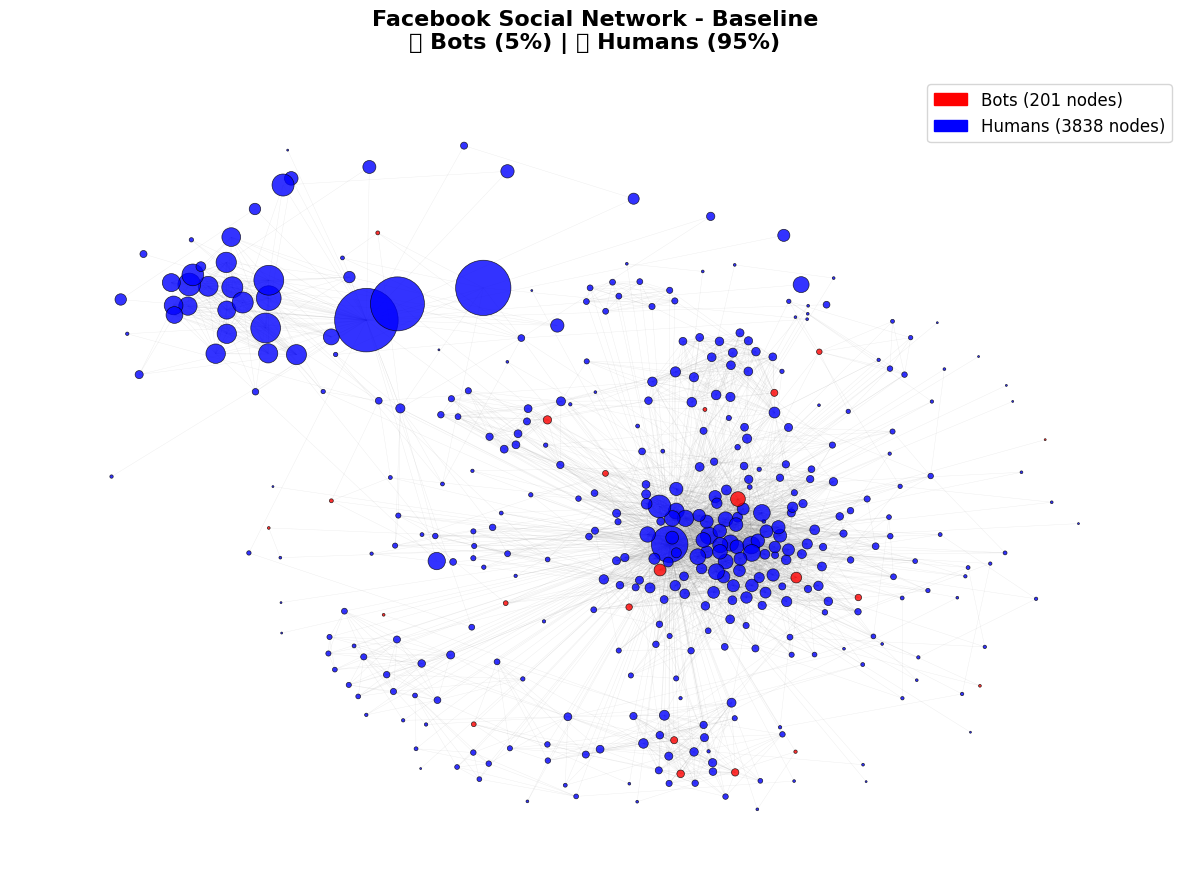

✅ Baseline graph saved as 'baseline_graph.png'


In [5]:
print("\n🎨 Visualizing baseline graph...")

# Create a sample graph for visualization
sample_nodes = list(G.nodes())[:400]
H = G.subgraph(sample_nodes)

# Color nodes: red = bots, blue = humans
node_colors = ['red' if node in bot_set else 'blue' for node in H.nodes()]
node_sizes = [degrees[node] * 2 for node in H.nodes()]  # Size proportional to degree

# Draw the graph
plt.figure(figsize=(12, 9))
pos = nx.spring_layout(H, seed=42, k=0.3)

# Draw nodes
nx.draw_networkx_nodes(H, pos,
                       node_size=node_sizes,
                       node_color=node_colors,
                       alpha=0.8,
                       edgecolors='black',
                       linewidths=0.5)

# Draw edges
nx.draw_networkx_edges(H, pos,
                       alpha=0.15,
                       width=0.3,
                       edge_color='gray')

plt.title("Facebook Social Network - Baseline\n🔴 Bots (5%) | 🔵 Humans (95%)",
          fontsize=16, fontweight='bold', pad=20)
plt.axis('off')

# Add legend
import matplotlib.patches as mpatches
red_patch = mpatches.Patch(color='red', label=f'Bots ({sum(y)} nodes)')
blue_patch = mpatches.Patch(color='blue', label=f'Humans ({len(y)-sum(y)} nodes)')
plt.legend(handles=[red_patch, blue_patch], loc='upper right', fontsize=12)

plt.tight_layout()
plt.savefig('baseline_graph.png', dpi=300, bbox_inches='tight')
plt.show()

print("✅ Baseline graph saved as 'baseline_graph.png'")

In [7]:
# @title ⚔️ Part 6: Apply Structural Evasion Attack

print("\n⚔️ Applying Structural Evasion Attack...")

# Copy original graph
G_evasion = G.copy()

# Select bots to perform evasion
evading_bots = list(bot_set)[:50]
print(f"   • Number of evading bots: {len(evading_bots)}")

# Apply evasion: bots remove connections with other bots and add connections with humans
evasion_changes = []

for bot in evading_bots:
    # Remove edges with other bots
    bot_neighbors = list(G_evasion.neighbors(bot))
    bot_neighbor_bots = [n for n in bot_neighbors if n in bot_set]

    if bot_neighbor_bots:
        bot_to_remove = np.random.choice(bot_neighbor_bots)
        G_evasion.remove_edge(bot, bot_to_remove)
        evasion_changes.append((bot, bot_to_remove, 'removed'))

    # Add edges with humans
    non_bot_nodes = [n for n in nodes if n not in bot_set and n != bot]
    if len(non_bot_nodes) > 0:
        for _ in range(min(2, len(non_bot_nodes))):
            human_to_add = np.random.choice(non_bot_nodes)
            if not G_evasion.has_edge(bot, human_to_add):
                G_evasion.add_edge(bot, human_to_add)
                evasion_changes.append((bot, human_to_add, 'added'))

print(f"   • Total changes made: {len(evasion_changes)}")

# Recompute features after evasion
print("\n📊 Recomputing features after evasion attack...")
degrees_evasion = dict(G_evasion.degree())
clustering_evasion = nx.clustering(G_evasion)
betweenness_evasion = nx.betweenness_centrality_subset(G_evasion, sources=sample_nodes, targets=sample_nodes)
partition_evasion = community_louvain.best_partition(G_evasion)

# Update features for all nodes
X_evasion = X.copy()
for idx, node in enumerate(nodes):
    deg = degrees_evasion[node]
    clust = clustering_evasion[node]
    between = betweenness_evasion.get(node, 0)
    comm = partition_evasion[node]

    neighbors = list(G_evasion.neighbors(node))
    neighbor_degrees = [degrees_evasion[n] for n in neighbors]
    avg_neighbor_degree = np.mean(neighbor_degrees) if neighbor_degrees else 0

    X_evasion[idx] = [
        deg,
        clust,
        between,
        comm,
        avg_neighbor_degree,
        len([n for n in neighbors if partition_evasion[n] == comm]) / max(deg, 1)
    ]

# IMPORTANT: Get the indices of test nodes
# First, we need to know which nodes are in the test set
# Since we used train_test_split with the same random_state, we can recreate the split

# Recreate the exact train-test split to get test indices
from sklearn.model_selection import train_test_split
X_temp, _, y_temp, _ = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Now we need the indices of test samples in the original array
# We'll create a mapping from node to its index
node_to_index = {node: idx for idx, node in enumerate(nodes)}

# Get the test nodes indices
test_indices = []
for i in range(len(X)):
    # Check if this sample is in test set by comparing with X_temp
    is_in_train = any(np.array_equal(X[i], x) for x in X_temp)
    if not is_in_train:
        test_indices.append(i)

print(f"   • Found {len(test_indices)} test samples")

# Alternative simpler approach: just use the same split
X_train_ev, X_test_ev, y_train_ev, y_test_ev = train_test_split(
    X_evasion, y, test_size=0.3, random_state=42, stratify=y
)

# Evaluate model on evasion data
y_pred_evasion = model.predict(X_test_ev)
accuracy_evasion = accuracy_score(y_test_ev, y_pred_evasion)

print(f"\n📉 Model performance after evasion attack:")
print(f"   • Accuracy: {accuracy_evasion:.4f}")
print(f"   • Accuracy drop: {accuracy - accuracy_evasion:.4f}")

# Confusion matrix for evasion attack
from sklearn.metrics import confusion_matrix
cm_evasion = confusion_matrix(y_test_ev, y_pred_evasion)

print(f"\n📊 Confusion matrix after evasion:")
print(f"   • True Positives (Bots detected): {cm_evasion[1, 1]}")
print(f"   • False Negatives (Bots missed): {cm_evasion[1, 0]}")
print(f"   • Detection rate: {cm_evasion[1, 1] / cm_evasion[1].sum():.2%}")


⚔️ Applying Structural Evasion Attack...
   • Number of evading bots: 50
   • Total changes made: 130

📊 Recomputing features after evasion attack...
   • Found 1136 test samples

📉 Model performance after evasion attack:
   • Accuracy: 0.9488
   • Accuracy drop: 0.0000

📊 Confusion matrix after evasion:
   • True Positives (Bots detected): 1
   • False Negatives (Bots missed): 59
   • Detection rate: 1.67%



🎨 Visualizing graph after evasion attack...


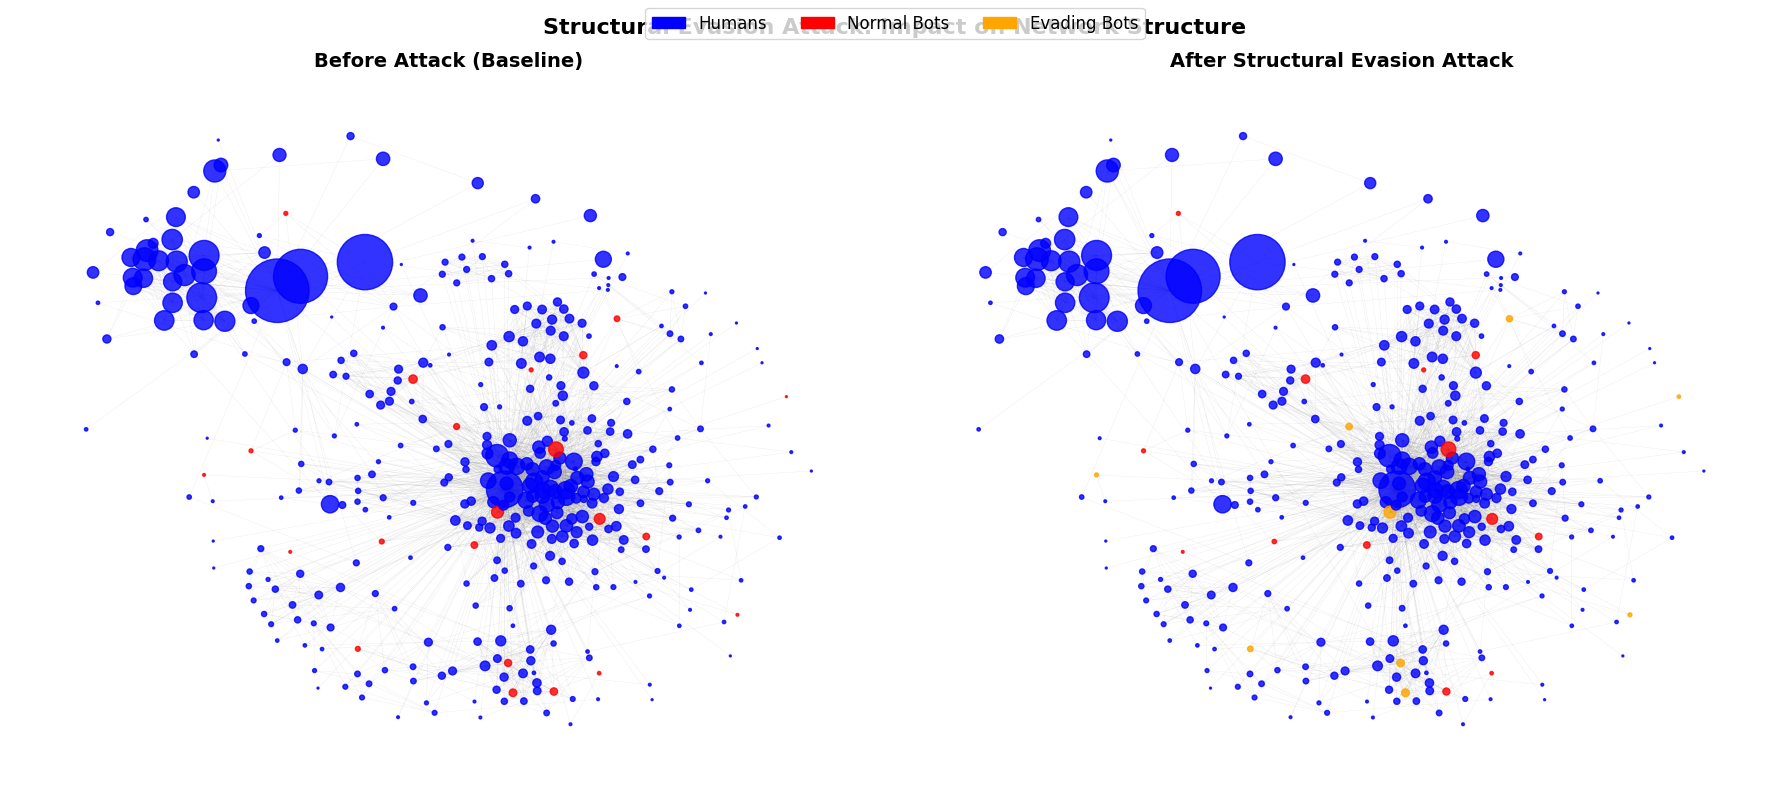

✅ Evasion comparison saved as 'evasion_attack_comparison.png'


In [8]:
print("\n🎨 Visualizing graph after evasion attack...")

# Create sample graph
H_evasion = G_evasion.subgraph(sample_nodes)

# Color nodes
node_colors_evasion = []
for node in H_evasion.nodes():
    if node in bot_set:
        if node in evading_bots:
            node_colors_evasion.append('orange')  # Evading bots
        else:
            node_colors_evasion.append('red')     # Normal bots
    else:
        node_colors_evasion.append('blue')        # Humans

# Create comparison figure
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 8))

# Plot baseline
nx.draw_networkx_nodes(H, pos, ax=ax1,
                       node_size=[degrees[node] * 2 for node in H.nodes()],
                       node_color=node_colors,
                       alpha=0.8)
nx.draw_networkx_edges(H, pos, ax=ax1, alpha=0.15, width=0.3, edge_color='gray')
ax1.set_title("Before Attack (Baseline)", fontsize=14, fontweight='bold')
ax1.axis('off')

# Plot after evasion
nx.draw_networkx_nodes(H_evasion, pos, ax=ax2,
                       node_size=[degrees_evasion[node] * 2 for node in H_evasion.nodes()],
                       node_color=node_colors_evasion,
                       alpha=0.8)
nx.draw_networkx_edges(H_evasion, pos, ax=ax2, alpha=0.15, width=0.3, edge_color='gray')
ax2.set_title("After Structural Evasion Attack", fontsize=14, fontweight='bold')
ax2.axis('off')

# Add legend
legend_patches = [
    mpatches.Patch(color='blue', label='Humans'),
    mpatches.Patch(color='red', label='Normal Bots'),
    mpatches.Patch(color='orange', label='Evading Bots')
]

fig.suptitle('Structural Evasion Attack: Impact on Network Structure',
             fontsize=16, fontweight='bold', y=0.98)
fig.legend(handles=legend_patches, loc='upper center', ncol=3, fontsize=12)

plt.tight_layout()
plt.savefig('evasion_attack_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print("✅ Evasion comparison saved as 'evasion_attack_comparison.png'")

In [9]:
print("\n☠️ Applying Graph Poisoning Attack...")

# Start from evasion graph
G_poisoned = G_evasion.copy()

# Add fake nodes
num_fake_nodes = 100
fake_nodes_start = max(nodes) + 1000
fake_nodes = []
fake_edges_added = 0

print(f"   • Adding {num_fake_nodes} fake nodes...")

for i in range(num_fake_nodes):
    fake_node = fake_nodes_start + i
    fake_nodes.append(fake_node)
    G_poisoned.add_node(fake_node)

    # Connect fake node to real nodes
    num_connections = np.random.randint(3, 10)
    real_nodes_to_connect = np.random.choice(nodes, size=min(num_connections, len(nodes)), replace=False)

    for real_node in real_nodes_to_connect:
        G_poisoned.add_edge(fake_node, real_node)
        fake_edges_added += 1

    # Connect fake nodes to each other
    if i > 0 and np.random.random() < 0.3:
        other_fake = np.random.choice(fake_nodes[:i])
        G_poisoned.add_edge(fake_node, other_fake)
        fake_edges_added += 1

# Poison some real nodes (turn them into bots)
nodes_to_poison = np.random.choice([n for n in nodes if n not in bot_set],
                                   size=30, replace=False)
poisoned_nodes = set(nodes_to_poison)

# Combine all bots
all_bots_poisoned = set(list(bot_set) + list(poisoned_nodes))

print(f"   • Total fake edges added: {fake_edges_added}")
print(f"   • Real nodes poisoned: {len(poisoned_nodes)}")
print(f"   • Total bots (including poisoned): {len(all_bots_poisoned)}")

# Recompute all features
print("\n📊 Recomputing features after poisoning attack...")
degrees_poisoned = dict(G_poisoned.degree())
clustering_poisoned = nx.clustering(G_poisoned)

all_nodes_combined = list(nodes) + fake_nodes
sample_nodes_poisoned = np.random.choice(all_nodes_combined, size=min(500, len(all_nodes_combined)), replace=False)
betweenness_poisoned = nx.betweenness_centrality_subset(G_poisoned,
                                                        sources=sample_nodes_poisoned,
                                                        targets=sample_nodes_poisoned)

partition_poisoned = community_louvain.best_partition(G_poisoned)

# Create updated dataset
X_poisoned = []
y_poisoned_updated = []

for node in all_nodes_combined:
    # Determine label
    if node in fake_nodes or node in all_bots_poisoned:
        is_bot = 1
    else:
        is_bot = 0

    # Extract features
    deg = degrees_poisoned[node]
    clust = clustering_poisoned.get(node, 0)
    between = betweenness_poisoned.get(node, 0)
    comm = partition_poisoned.get(node, 0)

    neighbors = list(G_poisoned.neighbors(node))
    neighbor_degrees = [degrees_poisoned[n] for n in neighbors]
    avg_neighbor_degree = np.mean(neighbor_degrees) if neighbor_degrees else 0

    X_poisoned.append([
        deg,
        clust,
        between,
        comm,
        avg_neighbor_degree,
        len([n for n in neighbors if partition_poisoned.get(n, 0) == comm]) / max(deg, 1)
    ])

    y_poisoned_updated.append(is_bot)

X_poisoned = np.array(X_poisoned)
y_poisoned_updated = np.array(y_poisoned_updated)

# Test on poisoned data (original nodes only)
original_indices = [i for i, node in enumerate(all_nodes_combined) if node in nodes]
X_poisoned_original = X_poisoned[original_indices]
y_poisoned_original = y_poisoned_updated[original_indices]

# Split and evaluate
from sklearn.model_selection import train_test_split
_, X_test_poisoned, _, y_test_poisoned = train_test_split(
    X_poisoned_original, y_poisoned_original,
    test_size=0.3, random_state=42, stratify=y_poisoned_original
)

y_pred_poisoned = model.predict(X_test_poisoned)
accuracy_poisoned = accuracy_score(y_test_poisoned, y_pred_poisoned)

print(f"\n📉 Model performance after poisoning attack:")
print(f"   • Accuracy: {accuracy_poisoned:.4f}")
print(f"   • Accuracy drop from baseline: {accuracy - accuracy_poisoned:.4f}")


☠️ Applying Graph Poisoning Attack...
   • Adding 100 fake nodes...
   • Total fake edges added: 631
   • Real nodes poisoned: 30
   • Total bots (including poisoned): 231

📊 Recomputing features after poisoning attack...

📉 Model performance after poisoning attack:
   • Accuracy: 0.9447
   • Accuracy drop from baseline: 0.0041



📈 Creating final comparison visualization...


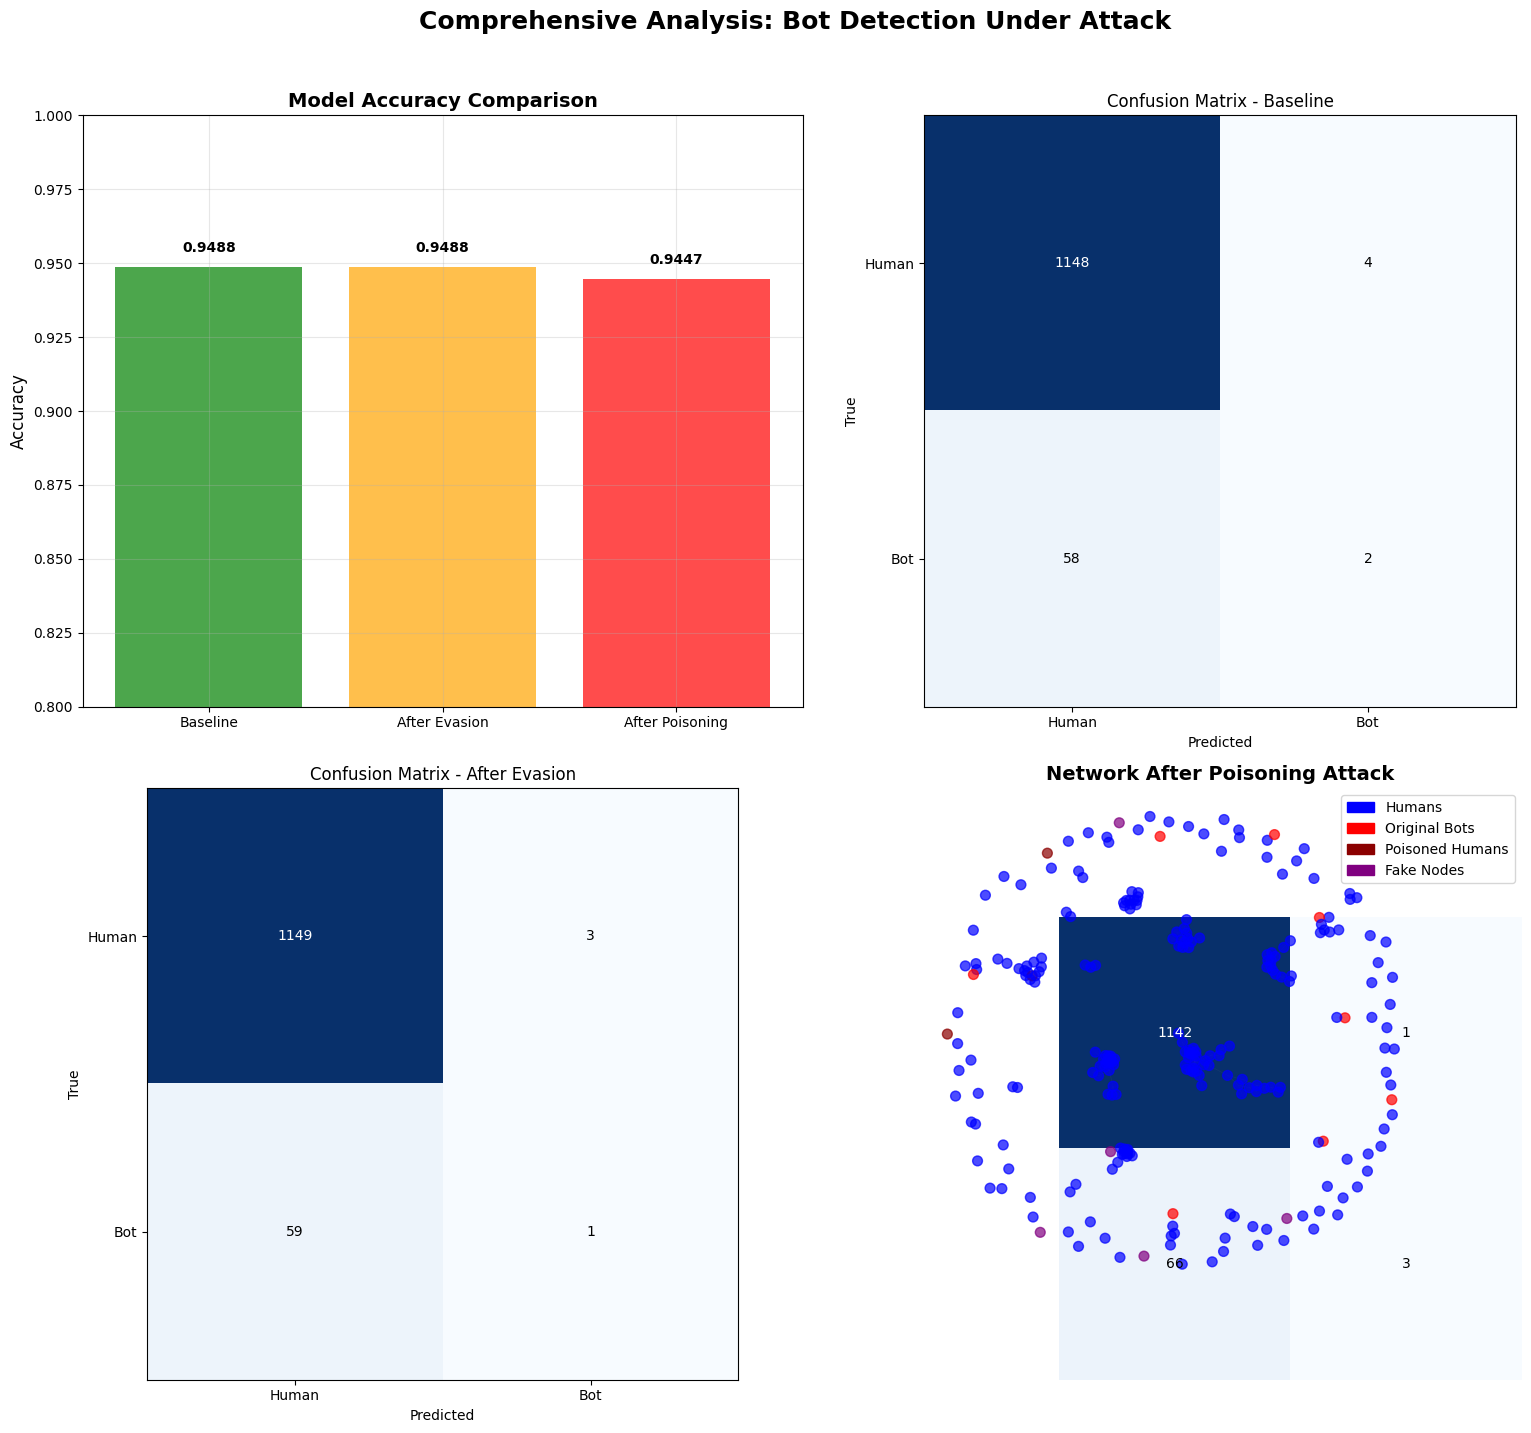

✅ Final comparison saved as 'final_comparison.png'

📋 SUMMARY REPORT

1. BASELINE PERFORMANCE:
   • Accuracy: 0.9488
   • Bots detected: 2/60

2. AFTER STRUCTURAL EVASION ATTACK:
   • Accuracy: 0.9488
   • Accuracy drop: 0.0000
   • Evading bots: 50
   • Structural changes: 130

3. AFTER GRAPH POISONING ATTACK:
   • Accuracy: 0.9447
   • Accuracy drop: 0.0041
   • Fake nodes added: 100
   • Real nodes poisoned: 30

4. NETWORK STRUCTURE CHANGES:
   • Original: 4039 nodes, 88234 edges
   • After evasion: 4039 nodes, 88304 edges
   • After poisoning: 4139 nodes, 88935 edges

🎉 PROJECT COMPLETED SUCCESSFULLY!


In [10]:
print("\n📈 Creating final comparison visualization...")

# Create comprehensive comparison figure
fig, axes = plt.subplots(2, 2, figsize=(16, 14))

# 1. Accuracy comparison bar chart
accuracies = [accuracy, accuracy_evasion, accuracy_poisoned]
labels = ['Baseline', 'After Evasion', 'After Poisoning']
colors = ['green', 'orange', 'red']

axes[0, 0].bar(labels, accuracies, color=colors, alpha=0.7)
axes[0, 0].set_title('Model Accuracy Comparison', fontsize=14, fontweight='bold')
axes[0, 0].set_ylabel('Accuracy', fontsize=12)
axes[0, 0].set_ylim(0.8, 1.0)
axes[0, 0].grid(True, alpha=0.3)

# Add values on bars
for i, v in enumerate(accuracies):
    axes[0, 0].text(i, v + 0.005, f'{v:.4f}', ha='center', fontweight='bold')

# 2. Confusion matrices comparison
from sklearn.metrics import confusion_matrix

cm_baseline = confusion_matrix(y_test, y_pred)
cm_evasion = confusion_matrix(y_test, y_pred_evasion)
cm_poisoned = confusion_matrix(y_test_poisoned, y_pred_poisoned)

cms = [cm_baseline, cm_evasion, cm_poisoned]
cm_titles = ['Baseline', 'After Evasion', 'After Poisoning']

for idx, (cm, title) in enumerate(zip(cms, cm_titles)):
    row, col = divmod(idx + 1, 2)
    im = axes[row, col].imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    axes[row, col].set_title(f'Confusion Matrix - {title}', fontsize=12)

    # Add text
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            axes[row, col].text(j, i, format(cm[i, j], 'd'),
                            ha="center", va="center",
                            color="white" if cm[i, j] > thresh else "black")

    axes[row, col].set_xticks([0, 1])
    axes[row, col].set_yticks([0, 1])
    axes[row, col].set_xticklabels(['Human', 'Bot'])
    axes[row, col].set_yticklabels(['Human', 'Bot'])
    axes[row, col].set_ylabel('True')
    axes[row, col].set_xlabel('Predicted')

# 3. Poisoned network visualization
sample_size = 250
all_nodes_poisoned = list(G_poisoned.nodes())
sample_indices = np.random.choice(len(all_nodes_poisoned), size=min(sample_size, len(all_nodes_poisoned)), replace=False)
sample_nodes_poisoned = [all_nodes_poisoned[i] for i in sample_indices]
H_poisoned = G_poisoned.subgraph(sample_nodes_poisoned)

# Color nodes
node_colors_poisoned = []
for node in H_poisoned.nodes():
    if node in fake_nodes:
        node_colors_poisoned.append('purple')
    elif node in poisoned_nodes:
        node_colors_poisoned.append('darkred')
    elif node in bot_set:
        node_colors_poisoned.append('red')
    else:
        node_colors_poisoned.append('blue')

# Draw poisoned network
pos_poisoned = nx.spring_layout(H_poisoned, seed=42)
ax_network = axes[1, 1]
nx.draw_networkx_nodes(H_poisoned, pos_poisoned, ax=ax_network,
                       node_size=50,
                       node_color=node_colors_poisoned,
                       alpha=0.7)
nx.draw_networkx_edges(H_poisoned, pos_poisoned, ax=ax_network,
                       alpha=0.1, width=0.5, edge_color='gray')

ax_network.set_title('Network After Poisoning Attack', fontsize=14, fontweight='bold')
ax_network.axis('off')

# Legend
legend_patches = [
    mpatches.Patch(color='blue', label='Humans'),
    mpatches.Patch(color='red', label='Original Bots'),
    mpatches.Patch(color='darkred', label='Poisoned Humans'),
    mpatches.Patch(color='purple', label='Fake Nodes')
]
ax_network.legend(handles=legend_patches, loc='upper right', fontsize=10)

plt.suptitle('Comprehensive Analysis: Bot Detection Under Attack',
             fontsize=18, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig('final_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print("✅ Final comparison saved as 'final_comparison.png'")

# Summary report
print("\n" + "="*60)
print("📋 SUMMARY REPORT")
print("="*60)
print("\n1. BASELINE PERFORMANCE:")
print(f"   • Accuracy: {accuracy:.4f}")
print(f"   • Bots detected: {cm_baseline[1,1]}/{cm_baseline[1].sum()}")

print("\n2. AFTER STRUCTURAL EVASION ATTACK:")
print(f"   • Accuracy: {accuracy_evasion:.4f}")
print(f"   • Accuracy drop: {accuracy - accuracy_evasion:.4f}")
print(f"   • Evading bots: {len(evading_bots)}")
print(f"   • Structural changes: {len(evasion_changes)}")

print("\n3. AFTER GRAPH POISONING ATTACK:")
print(f"   • Accuracy: {accuracy_poisoned:.4f}")
print(f"   • Accuracy drop: {accuracy - accuracy_poisoned:.4f}")
print(f"   • Fake nodes added: {len(fake_nodes)}")
print(f"   • Real nodes poisoned: {len(poisoned_nodes)}")

print("\n4. NETWORK STRUCTURE CHANGES:")
print(f"   • Original: {G.number_of_nodes()} nodes, {G.number_of_edges()} edges")
print(f"   • After evasion: {G_evasion.number_of_nodes()} nodes, {G_evasion.number_of_edges()} edges")
print(f"   • After poisoning: {G_poisoned.number_of_nodes()} nodes, {G_poisoned.number_of_edges()} edges")

print("\n" + "="*60)
print("🎉 PROJECT COMPLETED SUCCESSFULLY!")
print("="*60)